In [3]:
import numpy as np
import numpy.ma as ma
import os
import astropy.units as u
from astropy.io import ascii
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.stats import sigma_clipped_stats, sigma_clip
import subprocess
from astropy import units as u
from photutils.aperture import SkyCircularAperture, SkyCircularAnnulus, aperture_photometry
from astropy.io import fits
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
from tqdm import tqdm

In [5]:
process = subprocess.Popen("ls data", shell = "bin/bash", stdout=subprocess.PIPE)
all_files = str(process.communicate()[0])
all_files = all_files.strip("b'").split("\\n")[:-1]
image_files = []
for file_name in all_files:
    if file_name[-4:]=="fits":
        image_files.append(file_name)
image_files[:4]
# image_files[0][8:18]

['20230304170250-269-RA.wcs.proc.fits',
 '20230304170548-311-RA.wcs.proc.fits',
 '20230304170848-434-RA.wcs.proc.fits',
 '20230304171146-748-RA.wcs.proc.fits']

In [6]:
target = (124.7246375,73.09664611111111)
target_name = "UZ UMa"

zero_points = [(124.724104,73.180390),
               (125.000305, 73.187303),
               (125.135344, 73.118879),
               (125.300573, 73.143168),
               (125.107418, 72.979154),
               (124.809427, 73.237604),
               (125.487477, 73.025828),
               (124.984912, 72.881740),
               (125.166188, 72.839900),
               (124.311507, 72.802387)]

zero_point_magnitudes = {'g':[16.1290,16.7558,17.9789,15.9111,16.6301,14.4500,13.4090,15.1793,15.9971,12.6840],
                         'r':[15.0984,16.0908,16.7949,15.5345,15.8807,13.9953,12.7550,14.6579,14.9869,12.0790],
                         'i':[14.6628,15.8388,15.6108,15.4145,15.6035,13.8548,12.4680,14.5142,14.6238,11.8450],
                         'z':[14.4750,15.7218,15.0792,15.3899,15.4813,13.7976,12.3100,14.4658,14.4517,11.7290]}

arcseconds_per_pixel = 0.675961 # arcsec/pix
'''
zero_points = [(124.875126080,73.088720410),
               (124.985118130,73.102548680)]#,(124.8822085,73.1218904)]
zero_point_magnitudes = {'g':[20.5053,17.7577],
                         'r':[None,17.2501],
                         'i':[21.1920,17.0980],
                         'z':[20.6595,17.0245]}
'''
pass

In [7]:
def file_data_cords_filter(file_name):
    imageName = f'Data/{file_name}'
    f = fits.open(imageName)
    data = f[0].data  #This is the image array
    header = f[0].header
    #store the image WCS into an object
    w = WCS(header)
    try:
        return data, w, header["FILTER"]
    except KeyError:
        print(file_name + " Had a KeyError")

In [8]:
filter_count = {}
for i in range(len(image_files)):
    datya,w,filter = file_data_cords_filter(image_files[i])
    if filter in filter_count.keys():
        filter_count[filter]+=1
    else:
        filter_count[filter]=1
print(filter_count)

{'z': 9, 'i': 8, 'g': 9, 'r': 9}


In [9]:
def photometry(target_ra, target_dec, file_data, file_wcs, aperture_radius, annulus_inner, annulus_width):
    position = SkyCoord(ra = target_ra, dec = target_dec, unit = u.deg, frame = 'icrs')
    aperture = SkyCircularAperture(position, r = aperture_radius * u.arcsec)
    #Translate the apertures from sky coordinates to pixel coordinates
    pix_aperture = aperture.to_pixel(file_wcs)
    #Now compute the fluxes within these apertures on our data
    phot_table = aperture_photometry(file_data, pix_aperture)
    #Translating the output into usable format
    for col in phot_table.colnames:
            phot_table[col].info.format = '%.8g'    

    #Create the annulus aperture
    annulus_aperture = SkyCircularAnnulus(position, r_in = annulus_inner * u.arcsec, r_out = (annulus_inner + annulus_width) * u.arcsec)
    pix_annulus_aperture = annulus_aperture.to_pixel(file_wcs)
    #Measuring the flux inside an aperture annulus
    annulus_phot_table = aperture_photometry(file_data, pix_annulus_aperture)
    for col in annulus_phot_table.colnames:
            annulus_phot_table[col].info.format = '%.8g'    

    bkg_mean = annulus_phot_table[f'aperture_sum'] / pix_annulus_aperture.area
    counts = phot_table[f'aperture_sum'] - bkg_mean * pix_aperture.area
    return counts[0]


In [10]:
# Calculate zero_point error
def zero_point_error(zero_points, file_data, file_wcs, filter, aperture_radius, annulus_inner, annulus_width):
    fluxes = []
    for x in zero_points:
        fluxes.append(photometry(x[0], x[1], file_data, file_wcs, aperture_radius, annulus_inner, annulus_width))
    
    offsets = []
    for i in range(len(zero_points)):
        try:
            # print(fluxes[i])
            offsets.append(zero_point_magnitudes[filter][i]+2.5*np.log10(fluxes[i]))
        except TypeError:
            pass
    
    zero_mean, zero_med, zero_std = sigma_clipped_stats(offsets)
    return zero_med

In [11]:
aperture_radius = 11.0 # Determined after various comparisons in test_script.py
annulus_inner = 12.0
annulus_width = 17.0

In [12]:
time_series = {}
target_magnitudes = {}
uncorrected_tar_mags = {}

for file in image_files[:]:
    file_data, file_wcs, filter = file_data_cords_filter(file)
    correction = zero_point_error(zero_points, file_data, file_wcs, filter, aperture_radius, annulus_inner, annulus_width)
    target_flux = photometry(target[0], target[1], file_data, file_wcs, aperture_radius, annulus_inner, annulus_width)
    
    try:
        uncorrected_tar_mags[filter].append(- 2.5 * np.log10(target_flux))
    except KeyError:
        uncorrected_tar_mags[filter] = [- 2.5 * np.log10(target_flux)]

    try:
        target_magnitudes[filter].append(correction - 2.5 * np.log10(target_flux))
    except KeyError:
        target_magnitudes[filter] = [correction - 2.5 * np.log10(target_flux)]
    
    time_string = file[8:18]
    time_in_sec = int(time_string[0:2])*3600 + int(time_string[2:4])*60 + int(time_string[4:6]) + int(time_string[7:10])/1000
    try:
        time_series[filter].append(time_in_sec)
    except KeyError:
        time_series[filter] = [time_in_sec]


In [13]:
df = pd.DataFrame(columns=['time','tar_mag','filter'])

for x in time_series.keys():
    for i in range(len(time_series[x])):
        df.loc[len(df.index)] = [time_series[x][i],target_magnitudes[x][i],x]
df.head()

time    tar_mag filter
0  61370.269  14.420236      z
1  62278.228  14.432342      z
2  62837.873  14.374244      z
3  63739.645  14.383892      z
4  66798.808  14.313368      z

In [14]:
with open("correct_magnitudes.csv",'w') as f:
    f.write(df.to_csv())

Text(33.722222222222214, 0.5, 'Corrected Magnitude')

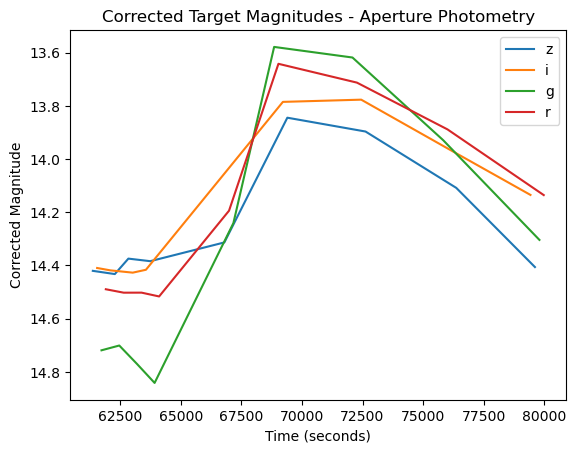

In [28]:
plt.gca().invert_yaxis()
for x in time_series.keys():
    plt.plot(time_series[x], target_magnitudes[x],label=x)
plt.legend()
plt.title("Corrected Target Magnitudes - Aperture Photometry")
plt.savefig("Corrected Target Magnitudes - Aperture Photometry")
plt.xlabel("Time (seconds)")
plt.ylabel("Corrected Magnitude")

Text(22.097222222222214, 0.5, 'Uncorrected Instrumental Magnitude')

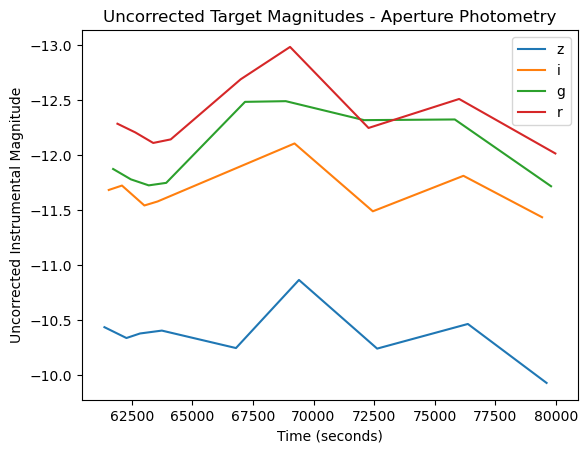

In [30]:
plt.gca().invert_yaxis()
for x in time_series.keys():
    plt.plot(time_series[x], uncorrected_tar_mags[x],label=x)
plt.legend()
plt.title("Uncorrected Target Magnitudes - Aperture Photometry")
plt.savefig("Uncorrected Target Magnitudes - Aperture Photometry")
plt.xlabel("Time (seconds)")
plt.ylabel("Uncorrected Instrumental Magnitude")

# Query Catalogue

In [17]:
from astroquery.vizier import Vizier

In [18]:
def query_catalogue(image_name, file_data, file_wcs, filter, file_dir = None, verbose = False):
    band_mag = filter + "mag"

    if file_dir==None:
        file_name = image_name
    else:
        file_name = file_dir + "/" + image_name

    #Get the RA and Dec of the center of the image
    [raImage, decImage] = file_wcs.all_pix2world(file_data.shape[0]/2, file_data.shape[1]/2, 1)

    #Set the box size to search for catalog stars
    boxsize = 30 # arcminutes

    #Magnitude cut-offs of sources to be cross-matched against
    maxmag = 18

    catNum = 'II/349'#This is the catalog number of PS1 in Vizier
    if verbose:
        print('\nQuerying Vizier %s around RA %.4f, Dec %.4f with a radius of %.4f arcmin'%(catNum, raImage, decImage, boxsize))

    #You can set the filters for the individual columns (magnitude range, number of detections) inside the Vizier query
    try:
        v = Vizier(columns=['*'], column_filters={band_mag:"<%.2f"%maxmag, "Nd":">6", "e_"+band_mag:"<0.362"}, row_limit=-1)
    except:
        print('I cannnot reach the Vizier database. Is the internet working?')

    Q = v.query_region(SkyCoord(ra = raImage, dec = decImage, unit = (u.deg, u.deg)), radius = str(boxsize)+'m', catalog=catNum, cache=False)
    #query vizier around (ra, dec) with a radius of boxsize

    #Convert the world coordinates of these stars to image coordinates
    ps1_imCoords = file_wcs.all_world2pix(Q[0]['RAJ2000'], Q[0]['DEJ2000'], 1)

    #Another round of filtering where we reject sources close to the edges
    good_cat_stars = Q[0][np.where((ps1_imCoords[0] > 500) & (ps1_imCoords[0] < 3500) & (ps1_imCoords[1] > 500) & (ps1_imCoords[1] < 3500))]

    return good_cat_stars


# PSF Photometry

In [19]:
def get_table_from_ldac(filename, frame=1):
    """
    Load an astropy table from a fits_ldac by frame (Since the ldac format has column 
    info for odd tables, giving it twce as many tables as a regular fits BinTableHDU,
    match the frame of a table to its corresponding frame in the ldac file).
    
    Parameters
    ----------
    filename: str
        Name of the file to open
    frame: int
        Number of the frame in a regular fits file
    """
    from astropy.table import Table
    if frame>0:
        frame = frame*2
    tbl = Table.read(filename, hdu=frame)
    return tbl

In [20]:
def psf_photometry(target_ra, target_dec, image_name, file_data, file_wcs, filter, good_stars_for_file, file_dir = None, verbose = False):
    band_mag = filter + "mag"

    if file_dir==None:
        file_name = image_name
    else:
        file_name = file_dir + "/" + image_name
    
    psf_file_name = "PSF_dir/"+image_name

    if verbose:
        print("\n","-"*40)
        print("File : " + file_name)


    configFile = 'photomCat.sex'
    catalogName = file_name+'.cat'
    paramName = 'photomCat.param'
    try:
        command = 'sex -c %s %s -CATALOG_NAME %s -PARAMETERS_NAME %s' % (configFile, file_name, catalogName, paramName)
        # command = 'sex -c %s %s -CATALOG_NAME %s' % (configFile, imageName, catalogName)
        if verbose:
            print('Executing command: %s' % command)
            rval = subprocess.run(command.split(), check=True)
        else:
            rval = subprocess.run(command.split(), check=True, stdout=subprocess.DEVNULL)
    except subprocess.CalledProcessError as err:
        print('Could not run sextractor with exit error %s'%err)

    psfConfigFile = 'psfex_conf.psfex'
    try:
        command = 'psfex -c %s %s' % (psfConfigFile, catalogName)
        if verbose:
            print('Executing command: %s' % command)
            rval = subprocess.run(command.split(), check=True)
        else:
            rval = subprocess.run(command.split(), check=True, stdout=subprocess.DEVNULL)
    except subprocess.CalledProcessError as err:
        print('Could not run psfex with exit error %s'%err)
        

    psfName = psf_file_name + '.psf'
    psfcatalogName = psf_file_name+'.psf.cat'
    psfparamName = 'photomPSF.param' #This is a new set of parameters to be obtained from SExtractor, including PSF-fit magnitudes
    try:
        #We are supplying SExtactor with the PSF model with the PSF_NAME option
        command = 'sex -c %s %s -CATALOG_NAME %s -PSF_NAME %s -PARAMETERS_NAME %s' % (configFile, file_name, psfcatalogName, psfName, psfparamName)
        if verbose:
            print("Executing command: %s" % command)
            rval = subprocess.run(command.split(), check=True)
        else:
            rval = subprocess.run(command.split(), check=True, stdout=subprocess.DEVNULL)
    except subprocess.CalledProcessError as err:
        print('Could not run sextractor with exit error %s'%err)

    psfsourceTable = get_table_from_ldac(psfcatalogName)
    #Selecting the clean sources away from image edges as before 
    cleanPSFSources = psfsourceTable[(psfsourceTable['FLAGS']==0) & (psfsourceTable['FLAGS_MODEL']==0)  & (psfsourceTable['FWHM_WORLD'] < 2) & (psfsourceTable['XMODEL_IMAGE']<3500) & (psfsourceTable['XMODEL_IMAGE']>500) &(psfsourceTable['YMODEL_IMAGE']<3500) &(psfsourceTable['YMODEL_IMAGE']>500)]

    psfsourceCatCoords = SkyCoord(ra=cleanPSFSources['ALPHAWIN_J2000'], dec=cleanPSFSources['DELTAWIN_J2000'], frame='icrs', unit='degree')
    ps1CatCoords = SkyCoord(ra=good_stars_for_file['RAJ2000'], dec=good_stars_for_file['DEJ2000'], frame='icrs', unit='degree')
    #Now cross match sources
    #Set the cross-match distance threshold to 0.6 arcsec, or just about one pixel
    photoDistThresh = arcseconds_per_pixel
    idx_psfimage, idx_psfps1, d2d, d3d = ps1CatCoords.search_around_sky(psfsourceCatCoords, photoDistThresh*u.arcsec)

    if verbose:
        print('Found %d good cross-matches'%len(idx_psfimage))

    psfoffsets = ma.array(good_stars_for_file[band_mag][idx_psfps1] - cleanPSFSources['MAG_POINTSOURCE'][idx_psfimage])
    #Compute sigma clipped statistics
    zero_psfmean, zero_psfmed, zero_psfstd = sigma_clipped_stats(psfoffsets)
    if verbose:
        print('PSF Mean ZP: %.2f\nPSF Median ZP: %.2f\nPSF STD ZP: %.2f'%(zero_psfmean, zero_psfmed, zero_psfstd))

    target_cords = SkyCoord(ra=[target_ra], dec=[target_dec], frame='icrs', unit='degree')
    idx_target, idx_cleanpsf_target, d2d, d3d = psfsourceCatCoords.search_around_sky(target_cords, photoDistThresh * u.arcsec)

    target_psfinstmag = cleanPSFSources[idx_cleanpsf_target]['MAG_POINTSOURCE'][0]
    target_psfinstmagerr = cleanPSFSources[idx_cleanpsf_target]['MAGERR_POINTSOURCE'][0]

    target_psfmag = zero_psfmed + target_psfinstmag
    target_psfmagerr = np.sqrt(target_psfinstmagerr**2 + zero_psfstd**2) # Correct error calculation done

    if verbose:
        print('PSF-fit magnitude of '+target_name+' in ' + filter + ' band is %.2f +/- %.2f'%(target_psfmag, target_psfmagerr))

    return target_psfmag, target_psfmagerr

In [21]:
image_files.pop(32) # Does not work for PSF photometry

'20230304220656-448-RA.wcs.proc.fits'

In [22]:
time_series_psf = {}
target_magnitudes_psf = {}
tar_mag_errs_psf = {}

for i in tqdm(range(len(image_files[:])),
              desc="Loading…",
              ascii=False, ncols=75):
    file = image_files[i]
    file_data, file_wcs, filter = file_data_cords_filter(file)
    
    good_stars_for_file = query_catalogue(file, file_data, file_wcs, filter, file_dir = "Data", verbose = True)
    tar_mag, tar_mag_err = psf_photometry(target[0], target[1], file, file_data, file_wcs, filter, good_stars_for_file, file_dir = "Data", verbose = True)

    try:
        target_magnitudes_psf[filter].append(tar_mag)
    except KeyError:
        target_magnitudes_psf[filter] = [tar_mag]

    try:
        tar_mag_errs_psf[filter].append(tar_mag_err)
    except KeyError:
        tar_mag_errs_psf[filter] = [tar_mag_err]
    
    time_string = file[8:18]
    time_in_sec = int(time_string[0:2])*3600 + int(time_string[2:4])*60 + int(time_string[4:6]) + int(time_string[7:10])/1000
    try:
        time_series_psf[filter].append(time_in_sec)
    except KeyError:
        time_series_psf[filter] = [time_in_sec]

Loading…:   0%|                                     | 0/34 [00:00<?, ?it/s]WARNING: FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60007.710304 from DATE-OBS'. [astropy.wcs.wcs]



Querying Vizier II/349 around RA 124.8992, Dec 73.0610 with a radius of 30.0000 arcmin

 ----------------------------------------
File : Data/20230304170250-269-RA.wcs.proc.fits
Executing command: sex -c photomCat.sex Data/20230304170250-269-RA.wcs.proc.fits -CATALOG_NAME Data/20230304170250-269-RA.wcs.proc.fits.cat -PARAMETERS_NAME photomCat.param


> 
----- SExtractor 2.28.0 started on 2023-04-27 at 12:53:23 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230304170250-269-RA.wcs.proc.fits
----- Measuring from: 20230304170250-269-RA.wcs.proc.fits
      "UZUMa" / no ext. header / 4096x4108 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line: 1024
> Setting up background map at line: 2048
> Setting up background map at line: 3072
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 393.599    RMS: 17.0319    / Threshold: 170.319    
> Scanning image
> Line:   25  Objects:        1 detected /        0 sextracted
> Line:   50  Objects:        2 detected /        0 sextracted
> Line:   75  Objects:        2 detected /        0 sextracted
> Line:  100  Ob

Executing command: psfex -c psfex_conf.psfex Data/20230304170250-269-RA.wcs.proc.fits.cat
Executing command: sex -c photomCat.sex Data/20230304170250-269-RA.wcs.proc.fits -CATALOG_NAME PSF_dir/20230304170250-269-RA.wcs.proc.fits.psf.cat -PSF_NAME PSF_dir/20230304170250-269-RA.wcs.proc.fits.psf -PARAMETERS_NAME photomPSF.param


> 
----- SExtractor 2.28.0 started on 2023-04-27 at 12:53:25 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230304170250-269-RA.wcs.proc.fits
----- Measuring from: 20230304170250-269-RA.wcs.proc.fits
      "UZUMa" / no ext. header / 4096x4108 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line: 1024
> Setting up background map at line: 2048
> Setting up background map at line: 3072
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 393.599    RMS: 17.0319    / Threshold: 170.319    
> Scanning image
> Line:    1  Objects:        0 detected /        0 sextracted
> Line:    2  Objects:        0 detected /        0 sextracte

Found 60 good cross-matches
PSF Mean ZP: 24.88
PSF Median ZP: 24.85
PSF STD ZP: 0.15
PSF-fit magnitude of UZ UMa in z band is 14.41 +/- 0.15

Querying Vizier II/349 around RA 124.8998, Dec 73.0615 with a radius of 30.0000 arcmin



 ----------------------------------------
File : Data/20230304170548-311-RA.wcs.proc.fits
Executing command: sex -c photomCat.sex Data/20230304170548-311-RA.wcs.proc.fits -CATALOG_NAME Data/20230304170548-311-RA.wcs.proc.fits.cat -PARAMETERS_NAME photomCat.param


> 
----- SExtractor 2.28.0 started on 2023-04-27 at 12:53:42 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230304170548-311-RA.wcs.proc.fits
----- Measuring from: 20230304170548-311-RA.wcs.proc.fits
      "UZUMa" / no ext. header / 4096x4108 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line: 1024
> Setting up background map at line: 2048
> Setting up background map at line: 3072
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 893.64     RMS: 26.9112    / Threshold: 269.112    
> Scanning image
> Line:   25  Objects:        1 detected /        0 sextracted
> Line:   50  Objects:        2 detected /        0 sextracted
> Line:   75  Objects:        3 detected /        0 sextracted
> Line:  100  Ob

Executing command: psfex -c psfex_conf.psfex Data/20230304170548-311-RA.wcs.proc.fits.cat
Executing command: sex -c photomCat.sex Data/20230304170548-311-RA.wcs.proc.fits -CATALOG_NAME PSF_dir/20230304170548-311-RA.wcs.proc.fits.psf.cat -PSF_NAME PSF_dir/20230304170548-311-RA.wcs.proc.fits.psf -PARAMETERS_NAME photomPSF.param


> 
----- SExtractor 2.28.0 started on 2023-04-27 at 12:53:44 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230304170548-311-RA.wcs.proc.fits
----- Measuring from: 20230304170548-311-RA.wcs.proc.fits
      "UZUMa" / no ext. header / 4096x4108 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line: 1024
> Setting up background map at line: 2048
> Setting up background map at line: 3072
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 893.64     RMS: 26.9112    / Threshold: 269.112    
> Scanning image
> Line:    1  Objects:        0 detected /        0 sextracted
> Line:    2  Objects:        0 detected /        0 sextracte

Found 113 good cross-matches
PSF Mean ZP: 26.30
PSF Median ZP: 26.27
PSF STD ZP: 0.22
PSF-fit magnitude of UZ UMa in i band is 14.55 +/- 0.22

Querying Vizier II/349 around RA 124.9008, Dec 73.0618 with a radius of 30.0000 arcmin



 ----------------------------------------
File : Data/20230304170848-434-RA.wcs.proc.fits
Executing command: sex -c photomCat.sex Data/20230304170848-434-RA.wcs.proc.fits -CATALOG_NAME Data/20230304170848-434-RA.wcs.proc.fits.cat -PARAMETERS_NAME photomCat.param


> 
----- SExtractor 2.28.0 started on 2023-04-27 at 12:54:18 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230304170848-434-RA.wcs.proc.fits
----- Measuring from: 20230304170848-434-RA.wcs.proc.fits
      "UZUMa" / no ext. header / 4096x4108 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line: 1024
> Setting up background map at line: 2048
> Setting up background map at line: 3072
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 1086.37    RMS: 29.4548    / Threshold: 294.548    
> Scanning image
> Line:   25  Objects:        1 detected /        0 sextracted
> Line:   50  Objects:        2 detected /        0 sextracted
> Line:   75  Objects:        2 detected /        0 sextracted
> Line:  100  Ob

Executing command: psfex -c psfex_conf.psfex Data/20230304170848-434-RA.wcs.proc.fits.cat
Executing command: sex -c photomCat.sex Data/20230304170848-434-RA.wcs.proc.fits -CATALOG_NAME PSF_dir/20230304170848-434-RA.wcs.proc.fits.psf.cat -PSF_NAME PSF_dir/20230304170848-434-RA.wcs.proc.fits.psf -PARAMETERS_NAME photomPSF.param


> 
----- SExtractor 2.28.0 started on 2023-04-27 at 12:54:20 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230304170848-434-RA.wcs.proc.fits
----- Measuring from: 20230304170848-434-RA.wcs.proc.fits
      "UZUMa" / no ext. header / 4096x4108 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line: 1024
> Setting up background map at line: 2048
> Setting up background map at line: 3072
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 1086.37    RMS: 29.4548    / Threshold: 294.548    
> Scanning image
> Line:    1  Objects:        0 detected /        0 sextracted
> Line:    2  Objects:        0 detected /        0 sextracte

Found 77 good cross-matches
PSF Mean ZP: 26.67
PSF Median ZP: 26.65
PSF STD ZP: 0.14
PSF-fit magnitude of UZ UMa in g band is 14.76 +/- 0.14

Querying Vizier II/349 around RA 124.9022, Dec 73.0622 with a radius of 30.0000 arcmin

 ----------------------------------------
File : Data/20230304171146-748-RA.wcs.proc.fits
Executing command: sex -c photomCat.sex Data/20230304171146-748-RA.wcs.proc.fits -CATALOG_NAME Data/20230304171146-748-RA.wcs.proc.fits.cat -PARAMETERS_NAME photomCat.param


> 
----- SExtractor 2.28.0 started on 2023-04-27 at 12:54:26 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230304171146-748-RA.wcs.proc.fits
----- Measuring from: 20230304171146-748-RA.wcs.proc.fits
      "UZUMa" / no ext. header / 4096x4108 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line: 1024
> Setting up background map at line: 2048
> Setting up background map at line: 3072
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 1443.68    RMS: 40.3908    / Threshold: 403.908    
> Scanning image
> Line:   25  Objects:        1 detected /        0 sextracted
> Line:   50  Objects:        2 detected /        0 sextracted
> Line:   75  Objects:        4 detected /        0 sextracted
> Line:  100  Ob

Executing command: psfex -c psfex_conf.psfex Data/20230304171146-748-RA.wcs.proc.fits.cat
Executing command: sex -c photomCat.sex Data/20230304171146-748-RA.wcs.proc.fits -CATALOG_NAME PSF_dir/20230304171146-748-RA.wcs.proc.fits.psf.cat -PSF_NAME PSF_dir/20230304171146-748-RA.wcs.proc.fits.psf -PARAMETERS_NAME photomPSF.param


> 
----- SExtractor 2.28.0 started on 2023-04-27 at 12:54:30 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230304171146-748-RA.wcs.proc.fits
----- Measuring from: 20230304171146-748-RA.wcs.proc.fits
      "UZUMa" / no ext. header / 4096x4108 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line: 1024
> Setting up background map at line: 2048
> Setting up background map at line: 3072
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 1443.68    RMS: 40.3908    / Threshold: 403.908    
> Scanning image
> Line:    1  Objects:        0 detected /        0 sextracted
> Line:    2  Objects:        0 detected /        0 sextracte

Found 100 good cross-matches
PSF Mean ZP: 26.97
PSF Median ZP: 26.95
PSF STD ZP: 0.16
PSF-fit magnitude of UZ UMa in r band is 14.56 +/- 0.16

Querying Vizier II/349 around RA 124.9036, Dec 73.0626 with a radius of 30.0000 arcmin



 ----------------------------------------
File : Data/20230304171453-429-RA.wcs.proc.fits
Executing command: sex -c photomCat.sex Data/20230304171453-429-RA.wcs.proc.fits -CATALOG_NAME Data/20230304171453-429-RA.wcs.proc.fits.cat -PARAMETERS_NAME photomCat.param


> 
----- SExtractor 2.28.0 started on 2023-04-27 at 12:54:57 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230304171453-429-RA.wcs.proc.fits
----- Measuring from: 20230304171453-429-RA.wcs.proc.fits
      "UZUMa" / no ext. header / 4096x4108 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line: 1024
> Setting up background map at line: 2048
> Setting up background map at line: 3072
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 909.889    RMS: 28.3223    / Threshold: 283.223    
> Scanning image
> Line:   25  Objects:        1 detected /        0 sextracted
> Line:   50  Objects:        2 detected /        0 sextracted
> Line:   75  Objects:        4 detected /        0 sextracted
> Line:  100  Ob

Executing command: psfex -c psfex_conf.psfex Data/20230304171453-429-RA.wcs.proc.fits.cat
Executing command: sex -c photomCat.sex Data/20230304171453-429-RA.wcs.proc.fits -CATALOG_NAME PSF_dir/20230304171453-429-RA.wcs.proc.fits.psf.cat -PSF_NAME PSF_dir/20230304171453-429-RA.wcs.proc.fits.psf -PARAMETERS_NAME photomPSF.param


> 
----- SExtractor 2.28.0 started on 2023-04-27 at 12:55:01 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230304171453-429-RA.wcs.proc.fits
----- Measuring from: 20230304171453-429-RA.wcs.proc.fits
      "UZUMa" / no ext. header / 4096x4108 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line: 1024
> Setting up background map at line: 2048
> Setting up background map at line: 3072
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 909.889    RMS: 28.3223    / Threshold: 283.223    
> Scanning image
> Line:    1  Objects:        0 detected /        0 sextracted
> Line:    2  Objects:        0 detected /        0 sextracte

Found 101 good cross-matches
PSF Mean ZP: 26.37
PSF Median ZP: 26.33
PSF STD ZP: 0.23
PSF-fit magnitude of UZ UMa in i band is 14.50 +/- 0.23

Querying Vizier II/349 around RA 124.9068, Dec 73.0630 with a radius of 30.0000 arcmin



 ----------------------------------------
File : Data/20230304171758-228-RA.wcs.proc.fits
Executing command: sex -c photomCat.sex Data/20230304171758-228-RA.wcs.proc.fits -CATALOG_NAME Data/20230304171758-228-RA.wcs.proc.fits.cat -PARAMETERS_NAME photomCat.param


> 
----- SExtractor 2.28.0 started on 2023-04-27 at 12:55:44 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230304171758-228-RA.wcs.proc.fits
----- Measuring from: 20230304171758-228-RA.wcs.proc.fits
      "UZUMa" / no ext. header / 4096x4108 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line: 1024
> Setting up background map at line: 2048
> Setting up background map at line: 3072
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 383.869    RMS: 18.036     / Threshold: 180.36     
> Scanning image
> Line:   25  Objects:        1 detected /        0 sextracted
> Line:   50  Objects:        2 detected /        0 sextracted
> Line:   75  Objects:        3 detected /        0 sextracted
> Line:  100  Ob

Executing command: psfex -c psfex_conf.psfex Data/20230304171758-228-RA.wcs.proc.fits.cat



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



Executing command: sex -c photomCat.sex Data/20230304171758-228-RA.wcs.proc.fits -CATALOG_NAME PSF_dir/20230304171758-228-RA.wcs.proc.fits.psf.cat -PSF_NAME PSF_dir/20230304171758-228-RA.wcs.proc.fits.psf -PARAMETERS_NAME photomPSF.param


> 
----- SExtractor 2.28.0 started on 2023-04-27 at 12:55:48 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230304171758-228-RA.wcs.proc.fits
----- Measuring from: 20230304171758-228-RA.wcs.proc.fits
      "UZUMa" / no ext. header / 4096x4108 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line: 1024
> Setting up background map at line: 2048
> Setting up background map at line: 3072
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 383.869    RMS: 18.036     / Threshold: 180.36     
> Scanning image
> Line:    1  Objects:        0 detected /        0 sextracted
> Line:    2  Objects:        0 detected /        0 sextracte

Found 69 good cross-matches
PSF Mean ZP: 24.95
PSF Median ZP: 24.90
PSF STD ZP: 0.23
PSF-fit magnitude of UZ UMa in z band is 14.37 +/- 0.23

Querying Vizier II/349 around RA 124.9065, Dec 73.0635 with a radius of 30.0000 arcmin



 ----------------------------------------
File : Data/20230304172102-309-RA.wcs.proc.fits
Executing command: sex -c photomCat.sex Data/20230304172102-309-RA.wcs.proc.fits -CATALOG_NAME Data/20230304172102-309-RA.wcs.proc.fits.cat -PARAMETERS_NAME photomCat.param


> 
----- SExtractor 2.28.0 started on 2023-04-27 at 12:56:17 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230304172102-309-RA.wcs.proc.fits
----- Measuring from: 20230304172102-309-RA.wcs.proc.fits
      "UZUMa" / no ext. header / 4096x4108 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line: 1024
> Setting up background map at line: 2048
> Setting up background map at line: 3072
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 1050.83    RMS: 35.537     / Threshold: 355.37     
> Scanning image
> Line:   25  Objects:        1 detected /        0 sextracted
> Line:   50  Objects:        2 detected /        0 sextracted
> Line:   75  Objects:        2 detected /        0 sextracted
> Line:  100  Ob

Executing command: psfex -c psfex_conf.psfex Data/20230304172102-309-RA.wcs.proc.fits.cat



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



Executing command: sex -c photomCat.sex Data/20230304172102-309-RA.wcs.proc.fits -CATALOG_NAME PSF_dir/20230304172102-309-RA.wcs.proc.fits.psf.cat -PSF_NAME PSF_dir/20230304172102-309-RA.wcs.proc.fits.psf -PARAMETERS_NAME photomPSF.param


> 
----- SExtractor 2.28.0 started on 2023-04-27 at 12:56:19 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230304172102-309-RA.wcs.proc.fits
----- Measuring from: 20230304172102-309-RA.wcs.proc.fits
      "UZUMa" / no ext. header / 4096x4108 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line: 1024
> Setting up background map at line: 2048
> Setting up background map at line: 3072
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 1050.83    RMS: 35.537     / Threshold: 355.37     
> Scanning image
> Line:    1  Objects:        0 detected /        0 sextracted
> Line:    2  Objects:        0 detected /        0 sextracte

Found 65 good cross-matches
PSF Mean ZP: 26.59
PSF Median ZP: 26.57
PSF STD ZP: 0.09
PSF-fit magnitude of UZ UMa in g band is 14.73 +/- 0.09

Querying Vizier II/349 around RA 124.9081, Dec 73.0639 with a radius of 30.0000 arcmin

 ----------------------------------------
File : Data/20230304172404-857-RA.wcs.proc.fits
Executing command: sex -c photomCat.sex Data/20230304172404-857-RA.wcs.proc.fits -CATALOG_NAME Data/20230304172404-857-RA.wcs.proc.fits.cat -PARAMETERS_NAME photomCat.param


> 
----- SExtractor 2.28.0 started on 2023-04-27 at 12:56:25 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230304172404-857-RA.wcs.proc.fits
----- Measuring from: 20230304172404-857-RA.wcs.proc.fits
      "UZUMa" / no ext. header / 4096x4108 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line: 1024
> Setting up background map at line: 2048
> Setting up background map at line: 3072
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 1424.95    RMS: 48.9075    / Threshold: 489.075    
> Scanning image
> Line:   25  Objects:        1 detected /        0 sextracted
> Line:   50  Objects:        2 detected /        0 sextracted
> Line:   75  Objects:        2 detected /        0 sextracted
> Line:  100  Ob

Executing command: psfex -c psfex_conf.psfex Data/20230304172404-857-RA.wcs.proc.fits.cat
Executing command: sex -c photomCat.sex Data/20230304172404-857-RA.wcs.proc.fits -CATALOG_NAME PSF_dir/20230304172404-857-RA.wcs.proc.fits.psf.cat -PSF_NAME PSF_dir/20230304172404-857-RA.wcs.proc.fits.psf -PARAMETERS_NAME photomPSF.param


> 
----- SExtractor 2.28.0 started on 2023-04-27 at 12:56:27 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230304172404-857-RA.wcs.proc.fits
----- Measuring from: 20230304172404-857-RA.wcs.proc.fits
      "UZUMa" / no ext. header / 4096x4108 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line: 1024
> Setting up background map at line: 2048
> Setting up background map at line: 3072
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 1424.95    RMS: 48.9075    / Threshold: 489.075    
> Scanning image
> Line:    1  Objects:        0 detected /        0 sextracted
> Line:    2  Objects:        0 detected /        0 sextracte

Found 83 good cross-matches
PSF Mean ZP: 27.03
PSF Median ZP: 27.02
PSF STD ZP: 0.24
PSF-fit magnitude of UZ UMa in r band is 14.59 +/- 0.24

Querying Vizier II/349 around RA 124.9111, Dec 73.0643 with a radius of 30.0000 arcmin

 ----------------------------------------
File : Data/20230304172717-873-RA.wcs.proc.fits
Executing command: sex -c photomCat.sex Data/20230304172717-873-RA.wcs.proc.fits -CATALOG_NAME Data/20230304172717-873-RA.wcs.proc.fits.cat -PARAMETERS_NAME photomCat.param


> 
----- SExtractor 2.28.0 started on 2023-04-27 at 12:56:53 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230304172717-873-RA.wcs.proc.fits
----- Measuring from: 20230304172717-873-RA.wcs.proc.fits
      "UZUMa" / no ext. header / 4096x4108 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line: 1024
> Setting up background map at line: 2048
> Setting up background map at line: 3072
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 388.708    RMS: 18.7729    / Threshold: 187.729    
> Scanning image
> Line:   25  Objects:        1 detected /        0 sextracted
> Line:   50  Objects:        2 detected /        0 sextracted
> Line:   75  Objects:        2 detected /        0 sextracted
> Line:  100  Ob

Executing command: psfex -c psfex_conf.psfex Data/20230304172717-873-RA.wcs.proc.fits.cat
Executing command: sex -c photomCat.sex Data/20230304172717-873-RA.wcs.proc.fits -CATALOG_NAME PSF_dir/20230304172717-873-RA.wcs.proc.fits.psf.cat -PSF_NAME PSF_dir/20230304172717-873-RA.wcs.proc.fits.psf -PARAMETERS_NAME photomPSF.param


> 
----- SExtractor 2.28.0 started on 2023-04-27 at 12:56:55 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230304172717-873-RA.wcs.proc.fits
----- Measuring from: 20230304172717-873-RA.wcs.proc.fits
      "UZUMa" / no ext. header / 4096x4108 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line: 1024
> Setting up background map at line: 2048
> Setting up background map at line: 3072
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 388.708    RMS: 18.7729    / Threshold: 187.729    
> Scanning image
> Line:    1  Objects:        0 detected /        0 sextracted
> Line:    2  Objects:        0 detected /        0 sextracte

Found 60 good cross-matches
PSF Mean ZP: 25.09
PSF Median ZP: 25.04
PSF STD ZP: 0.37
PSF-fit magnitude of UZ UMa in z band is 14.43 +/- 0.37

Querying Vizier II/349 around RA 124.9106, Dec 73.0649 with a radius of 30.0000 arcmin

 ----------------------------------------
File : Data/20230304173018-404-RA.wcs.proc.fits
Executing command: sex -c photomCat.sex Data/20230304173018-404-RA.wcs.proc.fits -CATALOG_NAME Data/20230304173018-404-RA.wcs.proc.fits.cat -PARAMETERS_NAME photomCat.param


> 
----- SExtractor 2.28.0 started on 2023-04-27 at 12:57:28 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230304173018-404-RA.wcs.proc.fits
----- Measuring from: 20230304173018-404-RA.wcs.proc.fits
      "UZUMa" / no ext. header / 4096x4108 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line: 1024
> Setting up background map at line: 2048
> Setting up background map at line: 3072
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 868.958    RMS: 33.5624    / Threshold: 335.624    
> Scanning image
> Line:   25  Objects:        1 detected /        0 sextracted
> Line:   50  Objects:        2 detected /        0 sextracted
> Line:   75  Objects:        5 detected /        0 sextracted
> Line:  100  Ob

Executing command: psfex -c psfex_conf.psfex Data/20230304173018-404-RA.wcs.proc.fits.cat
Executing command: sex -c photomCat.sex Data/20230304173018-404-RA.wcs.proc.fits -CATALOG_NAME PSF_dir/20230304173018-404-RA.wcs.proc.fits.psf.cat -PSF_NAME PSF_dir/20230304173018-404-RA.wcs.proc.fits.psf -PARAMETERS_NAME photomPSF.param


> 
----- SExtractor 2.28.0 started on 2023-04-27 at 12:57:35 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230304173018-404-RA.wcs.proc.fits
----- Measuring from: 20230304173018-404-RA.wcs.proc.fits
      "UZUMa" / no ext. header / 4096x4108 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line: 1024
> Setting up background map at line: 2048
> Setting up background map at line: 3072
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 868.958    RMS: 33.5624    / Threshold: 335.624    
> Scanning image
> Line:    1  Objects:        0 detected /        0 sextracted
> Line:    2  Objects:        0 detected /        0 sextracte

Found 101 good cross-matches
PSF Mean ZP: 26.22
PSF Median ZP: 26.18
PSF STD ZP: 0.25
PSF-fit magnitude of UZ UMa in i band is 14.53 +/- 0.25

Querying Vizier II/349 around RA 124.9119, Dec 73.0652 with a radius of 30.0000 arcmin



 ----------------------------------------
File : Data/20230304173318-348-RA.wcs.proc.fits
Executing command: sex -c photomCat.sex Data/20230304173318-348-RA.wcs.proc.fits -CATALOG_NAME Data/20230304173318-348-RA.wcs.proc.fits.cat -PARAMETERS_NAME photomCat.param


> 
----- SExtractor 2.28.0 started on 2023-04-27 at 12:58:07 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230304173318-348-RA.wcs.proc.fits
----- Measuring from: 20230304173318-348-RA.wcs.proc.fits
      "UZUMa" / no ext. header / 4096x4108 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line: 1024
> Setting up background map at line: 2048
> Setting up background map at line: 3072
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 1008.07    RMS: 31.5761    / Threshold: 315.761    
> Scanning image
> Line:   25  Objects:        1 detected /        0 sextracted
> Line:   50  Objects:        2 detected /        0 sextracted
> Line:   75  Objects:        2 detected /        0 sextracted
> Line:  100  Ob

Executing command: psfex -c psfex_conf.psfex Data/20230304173318-348-RA.wcs.proc.fits.cat
Executing command: sex -c photomCat.sex Data/20230304173318-348-RA.wcs.proc.fits -CATALOG_NAME PSF_dir/20230304173318-348-RA.wcs.proc.fits.psf.cat -PSF_NAME PSF_dir/20230304173318-348-RA.wcs.proc.fits.psf -PARAMETERS_NAME photomPSF.param


> 
----- SExtractor 2.28.0 started on 2023-04-27 at 12:58:09 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230304173318-348-RA.wcs.proc.fits
----- Measuring from: 20230304173318-348-RA.wcs.proc.fits
      "UZUMa" / no ext. header / 4096x4108 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line: 1024
> Setting up background map at line: 2048
> Setting up background map at line: 3072
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 1008.07    RMS: 31.5761    / Threshold: 315.761    
> Scanning image
> Line:    1  Objects:        0 detected /        0 sextracted
> Line:    2  Objects:        0 detected /        0 sextracte

Found 77 good cross-matches
PSF Mean ZP: 26.72
PSF Median ZP: 26.69
PSF STD ZP: 0.22
PSF-fit magnitude of UZ UMa in g band is 14.80 +/- 0.22

Querying Vizier II/349 around RA 124.9136, Dec 73.0657 with a radius of 30.0000 arcmin

 ----------------------------------------
File : Data/20230304173622-803-RA.wcs.proc.fits
Executing command: sex -c photomCat.sex Data/20230304173622-803-RA.wcs.proc.fits -CATALOG_NAME Data/20230304173622-803-RA.wcs.proc.fits.cat -PARAMETERS_NAME photomCat.param


> 
----- SExtractor 2.28.0 started on 2023-04-27 at 12:58:15 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230304173622-803-RA.wcs.proc.fits
----- Measuring from: 20230304173622-803-RA.wcs.proc.fits
      "UZUMa" / no ext. header / 4096x4108 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line: 1024
> Setting up background map at line: 2048
> Setting up background map at line: 3072
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 1323.07    RMS: 42.5648    / Threshold: 425.648    
> Scanning image
> Line:   25  Objects:        1 detected /        0 sextracted
> Line:   50  Objects:        2 detected /        0 sextracted
> Line:   75  Objects:        4 detected /        0 sextracted
> Line:  100  Ob

Executing command: psfex -c psfex_conf.psfex Data/20230304173622-803-RA.wcs.proc.fits.cat
Executing command: sex -c photomCat.sex Data/20230304173622-803-RA.wcs.proc.fits -CATALOG_NAME PSF_dir/20230304173622-803-RA.wcs.proc.fits.psf.cat -PSF_NAME PSF_dir/20230304173622-803-RA.wcs.proc.fits.psf -PARAMETERS_NAME photomPSF.param


> 
----- SExtractor 2.28.0 started on 2023-04-27 at 12:58:18 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230304173622-803-RA.wcs.proc.fits
----- Measuring from: 20230304173622-803-RA.wcs.proc.fits
      "UZUMa" / no ext. header / 4096x4108 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line: 1024
> Setting up background map at line: 2048
> Setting up background map at line: 3072
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 1323.07    RMS: 42.5648    / Threshold: 425.648    
> Scanning image
> Line:    1  Objects:        0 detected /        0 sextracted
> Line:    2  Objects:        0 detected /        0 sextracte

Found 109 good cross-matches
PSF Mean ZP: 26.83
PSF Median ZP: 26.80
PSF STD ZP: 0.19
PSF-fit magnitude of UZ UMa in r band is 14.59 +/- 0.19

Querying Vizier II/349 around RA 124.9150, Dec 73.0662 with a radius of 30.0000 arcmin

 ----------------------------------------
File : Data/20230304173921-828-RA.wcs.proc.fits
Executing command: sex -c photomCat.sex Data/20230304173921-828-RA.wcs.proc.fits -CATALOG_NAME Data/20230304173921-828-RA.wcs.proc.fits.cat -PARAMETERS_NAME photomCat.param


> 
----- SExtractor 2.28.0 started on 2023-04-27 at 12:58:38 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230304173921-828-RA.wcs.proc.fits
----- Measuring from: 20230304173921-828-RA.wcs.proc.fits
      "UZUMa" / no ext. header / 4096x4108 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line: 1024
> Setting up background map at line: 2048
> Setting up background map at line: 3072
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 828.765    RMS: 33.1158    / Threshold: 331.158    
> Scanning image
> Line:   25  Objects:        1 detected /        0 sextracted
> Line:   50  Objects:        3 detected /        0 sextracted
> Line:   75  Objects:       13 detected /        0 sextracted
> Line:  100  Ob

Executing command: psfex -c psfex_conf.psfex Data/20230304173921-828-RA.wcs.proc.fits.cat
Executing command: sex -c photomCat.sex Data/20230304173921-828-RA.wcs.proc.fits -CATALOG_NAME PSF_dir/20230304173921-828-RA.wcs.proc.fits.psf.cat -PSF_NAME PSF_dir/20230304173921-828-RA.wcs.proc.fits.psf -PARAMETERS_NAME photomPSF.param


> 
----- SExtractor 2.28.0 started on 2023-04-27 at 12:58:43 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230304173921-828-RA.wcs.proc.fits
----- Measuring from: 20230304173921-828-RA.wcs.proc.fits
      "UZUMa" / no ext. header / 4096x4108 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line: 1024
> Setting up background map at line: 2048
> Setting up background map at line: 3072
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 828.765    RMS: 33.1158    / Threshold: 331.158    
> Scanning image
> Line:    1  Objects:        0 detected /        0 sextracted
> Line:    2  Objects:        0 detected /        0 sextracte

Found 118 good cross-matches
PSF Mean ZP: 26.45
PSF Median ZP: 26.39
PSF STD ZP: 0.36
PSF-fit magnitude of UZ UMa in i band is 14.59 +/- 0.36

Querying Vizier II/349 around RA 124.9176, Dec 73.0665 with a radius of 30.0000 arcmin



 ----------------------------------------
File : Data/20230304174219-645-RA.wcs.proc.fits
Executing command: sex -c photomCat.sex Data/20230304174219-645-RA.wcs.proc.fits -CATALOG_NAME Data/20230304174219-645-RA.wcs.proc.fits.cat -PARAMETERS_NAME photomCat.param


> 
----- SExtractor 2.28.0 started on 2023-04-27 at 12:59:12 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230304174219-645-RA.wcs.proc.fits
----- Measuring from: 20230304174219-645-RA.wcs.proc.fits
      "UZUMa" / no ext. header / 4096x4108 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line: 1024
> Setting up background map at line: 2048
> Setting up background map at line: 3072
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 345.591    RMS: 18.2883    / Threshold: 182.883    
> Scanning image
> Line:   25  Objects:        1 detected /        0 sextracted
> Line:   50  Objects:        2 detected /        0 sextracted
> Line:   75  Objects:        2 detected /        0 sextracted
> Line:  100  Ob

Executing command: psfex -c psfex_conf.psfex Data/20230304174219-645-RA.wcs.proc.fits.cat



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



Executing command: sex -c photomCat.sex Data/20230304174219-645-RA.wcs.proc.fits -CATALOG_NAME PSF_dir/20230304174219-645-RA.wcs.proc.fits.psf.cat -PSF_NAME PSF_dir/20230304174219-645-RA.wcs.proc.fits.psf -PARAMETERS_NAME photomPSF.param


> 
----- SExtractor 2.28.0 started on 2023-04-27 at 12:59:14 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230304174219-645-RA.wcs.proc.fits
----- Measuring from: 20230304174219-645-RA.wcs.proc.fits
      "UZUMa" / no ext. header / 4096x4108 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line: 1024
> Setting up background map at line: 2048
> Setting up background map at line: 3072
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 345.591    RMS: 18.2883    / Threshold: 182.883    
> Scanning image
> Line:    1  Objects:        0 detected /        0 sextracted
> Line:    2  Objects:        0 detected /        0 sextracte

Found 63 good cross-matches
PSF Mean ZP: 25.08
PSF Median ZP: 25.00
PSF STD ZP: 0.32
PSF-fit magnitude of UZ UMa in z band is 14.55 +/- 0.32

Querying Vizier II/349 around RA 124.9173, Dec 73.0671 with a radius of 30.0000 arcmin

 ----------------------------------------
File : Data/20230304174519-654-RA.wcs.proc.fits
Executing command: sex -c photomCat.sex Data/20230304174519-654-RA.wcs.proc.fits -CATALOG_NAME Data/20230304174519-654-RA.wcs.proc.fits.cat -PARAMETERS_NAME photomCat.param


> 
----- SExtractor 2.28.0 started on 2023-04-27 at 12:59:35 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230304174519-654-RA.wcs.proc.fits
----- Measuring from: 20230304174519-654-RA.wcs.proc.fits
      "UZUMa" / no ext. header / 4096x4108 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line: 1024
> Setting up background map at line: 2048
> Setting up background map at line: 3072
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 964.023    RMS: 28.2507    / Threshold: 282.507    
> Scanning image
> Line:   25  Objects:        1 detected /        0 sextracted
> Line:   50  Objects:        2 detected /        0 sextracted
> Line:   75  Objects:        2 detected /        0 sextracted
> Line:  100  Ob

Executing command: psfex -c psfex_conf.psfex Data/20230304174519-654-RA.wcs.proc.fits.cat
Executing command: sex -c photomCat.sex Data/20230304174519-654-RA.wcs.proc.fits -CATALOG_NAME PSF_dir/20230304174519-654-RA.wcs.proc.fits.psf.cat -PSF_NAME PSF_dir/20230304174519-654-RA.wcs.proc.fits.psf -PARAMETERS_NAME photomPSF.param


> 
----- SExtractor 2.28.0 started on 2023-04-27 at 12:59:37 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230304174519-654-RA.wcs.proc.fits
----- Measuring from: 20230304174519-654-RA.wcs.proc.fits
      "UZUMa" / no ext. header / 4096x4108 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line: 1024
> Setting up background map at line: 2048
> Setting up background map at line: 3072
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 964.023    RMS: 28.2507    / Threshold: 282.507    
> Scanning image
> Line:    1  Objects:        0 detected /        0 sextracted
> Line:    2  Objects:        0 detected /        0 sextracte

Found 76 good cross-matches
PSF Mean ZP: 26.75
PSF Median ZP: 26.75
PSF STD ZP: 0.24
PSF-fit magnitude of UZ UMa in g band is 14.82 +/- 0.24

Querying Vizier II/349 around RA 124.9197, Dec 73.0675 with a radius of 30.0000 arcmin



 ----------------------------------------
File : Data/20230304174826-345-RA.wcs.proc.fits
Executing command: sex -c photomCat.sex Data/20230304174826-345-RA.wcs.proc.fits -CATALOG_NAME Data/20230304174826-345-RA.wcs.proc.fits.cat -PARAMETERS_NAME photomCat.param


> 
----- SExtractor 2.28.0 started on 2023-04-27 at 12:59:44 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230304174826-345-RA.wcs.proc.fits
----- Measuring from: 20230304174826-345-RA.wcs.proc.fits
      "UZUMa" / no ext. header / 4096x4108 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line: 1024
> Setting up background map at line: 2048
> Setting up background map at line: 3072
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 1031.81    RMS: 27.1049    / Threshold: 271.049    
> Scanning image
> Line:   25  Objects:        1 detected /        0 sextracted
> Line:   50  Objects:        2 detected /        0 sextracted
> Line:   75  Objects:        4 detected /        0 sextracted
> Line:  100  Ob

Executing command: psfex -c psfex_conf.psfex Data/20230304174826-345-RA.wcs.proc.fits.cat
Executing command: sex -c photomCat.sex Data/20230304174826-345-RA.wcs.proc.fits -CATALOG_NAME PSF_dir/20230304174826-345-RA.wcs.proc.fits.psf.cat -PSF_NAME PSF_dir/20230304174826-345-RA.wcs.proc.fits.psf -PARAMETERS_NAME photomPSF.param


> 
----- SExtractor 2.28.0 started on 2023-04-27 at 12:59:46 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230304174826-345-RA.wcs.proc.fits
----- Measuring from: 20230304174826-345-RA.wcs.proc.fits
      "UZUMa" / no ext. header / 4096x4108 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line: 1024
> Setting up background map at line: 2048
> Setting up background map at line: 3072
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 1031.81    RMS: 27.1049    / Threshold: 271.049    
> Scanning image
> Line:    1  Objects:        0 detected /        0 sextracted
> Line:    2  Objects:        0 detected /        0 sextracte

Found 129 good cross-matches
PSF Mean ZP: 26.73
PSF Median ZP: 26.73
PSF STD ZP: 0.15
PSF-fit magnitude of UZ UMa in r band is 14.54 +/- 0.15

Querying Vizier II/349 around RA 124.8281, Dec 73.0772 with a radius of 30.0000 arcmin

 ----------------------------------------
File : Data/20230304183318-808-RA.wcs.proc.fits
Executing command: sex -c photomCat.sex Data/20230304183318-808-RA.wcs.proc.fits -CATALOG_NAME Data/20230304183318-808-RA.wcs.proc.fits.cat -PARAMETERS_NAME photomCat.param


> 
----- SExtractor 2.28.0 started on 2023-04-27 at 13:00:01 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230304183318-808-RA.wcs.proc.fits
----- Measuring from: 20230304183318-808-RA.wcs.proc.fits
      "UZUMa" / no ext. header / 4096x4108 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line: 1024
> Setting up background map at line: 2048
> Setting up background map at line: 3072
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 194.734    RMS: 12.8828    / Threshold: 128.828    
> Scanning image
> Line:   25  Objects:        0 detected /        0 sextracted
> Line:   50  Objects:        0 detected /        0 sextracted
> Line:   75  Objects:        0 detected /        0 sextracted
> Line:  100  Ob

Executing command: psfex -c psfex_conf.psfex Data/20230304183318-808-RA.wcs.proc.fits.cat
Executing command: sex -c photomCat.sex Data/20230304183318-808-RA.wcs.proc.fits -CATALOG_NAME PSF_dir/20230304183318-808-RA.wcs.proc.fits.psf.cat -PSF_NAME PSF_dir/20230304183318-808-RA.wcs.proc.fits.psf -PARAMETERS_NAME photomPSF.param


> 
----- SExtractor 2.28.0 started on 2023-04-27 at 13:00:03 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230304183318-808-RA.wcs.proc.fits
----- Measuring from: 20230304183318-808-RA.wcs.proc.fits
      "UZUMa" / no ext. header / 4096x4108 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line: 1024
> Setting up background map at line: 2048
> Setting up background map at line: 3072
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 194.734    RMS: 12.8828    / Threshold: 128.828    
> Scanning image
> Line:    1  Objects:        0 detected /        0 sextracted
> Line:    2  Objects:        0 detected /        0 sextracte

Found 67 good cross-matches
PSF Mean ZP: 24.47
PSF Median ZP: 24.46
PSF STD ZP: 0.10
PSF-fit magnitude of UZ UMa in z band is 14.32 +/- 0.10

Querying Vizier II/349 around RA 124.8270, Dec 73.0774 with a radius of 30.0000 arcmin



 ----------------------------------------
File : Data/20230304183632-055-RA.wcs.proc.fits
Executing command: sex -c photomCat.sex Data/20230304183632-055-RA.wcs.proc.fits -CATALOG_NAME Data/20230304183632-055-RA.wcs.proc.fits.cat -PARAMETERS_NAME photomCat.param


> 
----- SExtractor 2.28.0 started on 2023-04-27 at 13:00:11 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230304183632-055-RA.wcs.proc.fits
----- Measuring from: 20230304183632-055-RA.wcs.proc.fits
      "UZUMa" / no ext. header / 4096x4108 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line: 1024
> Setting up background map at line: 2048
> Setting up background map at line: 3072
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 1053.44    RMS: 23.57      / Threshold: 235.7      
> Scanning image
> Line:   25  Objects:        1 detected /        0 sextracted
> Line:   50  Objects:        2 detected /        0 sextracted
> Line:   75  Objects:        2 detected /        0 sextracted
> Line:  100  Ob

Executing command: psfex -c psfex_conf.psfex Data/20230304183632-055-RA.wcs.proc.fits.cat
Executing command: sex -c photomCat.sex Data/20230304183632-055-RA.wcs.proc.fits -CATALOG_NAME PSF_dir/20230304183632-055-RA.wcs.proc.fits.psf.cat -PSF_NAME PSF_dir/20230304183632-055-RA.wcs.proc.fits.psf -PARAMETERS_NAME photomPSF.param


> 
----- SExtractor 2.28.0 started on 2023-04-27 at 13:00:13 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230304183632-055-RA.wcs.proc.fits
----- Measuring from: 20230304183632-055-RA.wcs.proc.fits
      "UZUMa" / no ext. header / 4096x4108 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line: 1024
> Setting up background map at line: 2048
> Setting up background map at line: 3072
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 1053.44    RMS: 23.57      / Threshold: 235.7      
> Scanning image
> Line:    1  Objects:        0 detected /        0 sextracted
> Line:    2  Objects:        0 detected /        0 sextracte

Found 149 good cross-matches
PSF Mean ZP: 26.89
PSF Median ZP: 26.89
PSF STD ZP: 0.09
PSF-fit magnitude of UZ UMa in r band is 14.21 +/- 0.09

Querying Vizier II/349 around RA 124.8272, Dec 73.0775 with a radius of 30.0000 arcmin



 ----------------------------------------
File : Data/20230304183931-513-RA.wcs.proc.fits
Executing command: sex -c photomCat.sex Data/20230304183931-513-RA.wcs.proc.fits -CATALOG_NAME Data/20230304183931-513-RA.wcs.proc.fits.cat -PARAMETERS_NAME photomCat.param


> 
----- SExtractor 2.28.0 started on 2023-04-27 at 13:00:25 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230304183931-513-RA.wcs.proc.fits
----- Measuring from: 20230304183931-513-RA.wcs.proc.fits
      "UZUMa" / no ext. header / 4096x4108 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line: 1024
> Setting up background map at line: 2048
> Setting up background map at line: 3072
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 949.32     RMS: 21.9911    / Threshold: 219.911    
> Scanning image
> Line:   25  Objects:        0 detected /        0 sextracted
> Line:   50  Objects:        0 detected /        0 sextracted
> Line:   75  Objects:        0 detected /        0 sextracted
> Line:  100  Ob

Executing command: psfex -c psfex_conf.psfex Data/20230304183931-513-RA.wcs.proc.fits.cat
Executing command: sex -c photomCat.sex Data/20230304183931-513-RA.wcs.proc.fits -CATALOG_NAME PSF_dir/20230304183931-513-RA.wcs.proc.fits.psf.cat -PSF_NAME PSF_dir/20230304183931-513-RA.wcs.proc.fits.psf -PARAMETERS_NAME photomPSF.param


> 
----- SExtractor 2.28.0 started on 2023-04-27 at 13:00:27 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230304183931-513-RA.wcs.proc.fits
----- Measuring from: 20230304183931-513-RA.wcs.proc.fits
      "UZUMa" / no ext. header / 4096x4108 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line: 1024
> Setting up background map at line: 2048
> Setting up background map at line: 3072
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 949.32     RMS: 21.9911    / Threshold: 219.911    
> Scanning image
> Line:    1  Objects:        0 detected /        0 sextracted
> Line:    2  Objects:        0 detected /        0 sextracte

Found 114 good cross-matches
PSF Mean ZP: 26.74
PSF Median ZP: 26.73
PSF STD ZP: 0.10
PSF-fit magnitude of UZ UMa in g band is 14.25 +/- 0.10

Querying Vizier II/349 around RA 124.8356, Dec 73.0787 with a radius of 30.0000 arcmin

 ----------------------------------------
File : Data/20230304190733-065-RA.wcs.proc.fits
Executing command: sex -c photomCat.sex Data/20230304190733-065-RA.wcs.proc.fits -CATALOG_NAME Data/20230304190733-065-RA.wcs.proc.fits.cat -PARAMETERS_NAME photomCat.param


> 
----- SExtractor 2.28.0 started on 2023-04-27 at 13:00:33 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230304190733-065-RA.wcs.proc.fits
----- Measuring from: 20230304190733-065-RA.wcs.proc.fits
      "UZUMa" / no ext. header / 4096x4108 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line: 1024
> Setting up background map at line: 2048
> Setting up background map at line: 3072
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 556.493    RMS: 18.9428    / Threshold: 189.428    
> Scanning image
> Line:   25  Objects:        0 detected /        0 sextracted
> Line:   50  Objects:        0 detected /        0 sextracted
> Line:   75  Objects:        0 detected /        0 sextracted
> Line:  100  Ob

Executing command: psfex -c psfex_conf.psfex Data/20230304190733-065-RA.wcs.proc.fits.cat
Executing command: sex -c photomCat.sex Data/20230304190733-065-RA.wcs.proc.fits -CATALOG_NAME PSF_dir/20230304190733-065-RA.wcs.proc.fits.psf.cat -PSF_NAME PSF_dir/20230304190733-065-RA.wcs.proc.fits.psf -PARAMETERS_NAME photomPSF.param


> 
----- SExtractor 2.28.0 started on 2023-04-27 at 13:00:36 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230304190733-065-RA.wcs.proc.fits
----- Measuring from: 20230304190733-065-RA.wcs.proc.fits
      "UZUMa" / no ext. header / 4096x4108 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line: 1024
> Setting up background map at line: 2048
> Setting up background map at line: 3072
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 556.493    RMS: 18.9428    / Threshold: 189.428    
> Scanning image
> Line:    1  Objects:        0 detected /        0 sextracted
> Line:    2  Objects:        0 detected /        0 sextracte

Found 97 good cross-matches
PSF Mean ZP: 26.06
PSF Median ZP: 26.05
PSF STD ZP: 0.17
PSF-fit magnitude of UZ UMa in g band is 13.59 +/- 0.17

Querying Vizier II/349 around RA 124.8365, Dec 73.0788 with a radius of 30.0000 arcmin

 ----------------------------------------
File : Data/20230304191030-443-RA.wcs.proc.fits
Executing command: sex -c photomCat.sex Data/20230304191030-443-RA.wcs.proc.fits -CATALOG_NAME Data/20230304191030-443-RA.wcs.proc.fits.cat -PARAMETERS_NAME photomCat.param


> 
----- SExtractor 2.28.0 started on 2023-04-27 at 13:00:42 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230304191030-443-RA.wcs.proc.fits
----- Measuring from: 20230304191030-443-RA.wcs.proc.fits
      "UZUMa" / no ext. header / 4096x4108 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line: 1024
> Setting up background map at line: 2048
> Setting up background map at line: 3072
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 861.879    RMS: 24.7209    / Threshold: 247.209    
> Scanning image
> Line:   25  Objects:        1 detected /        0 sextracted
> Line:   50  Objects:        2 detected /        0 sextracted
> Line:   75  Objects:        2 detected /        0 sextracted
> Line:  100  Ob

Executing command: psfex -c psfex_conf.psfex Data/20230304191030-443-RA.wcs.proc.fits.cat
Executing command: sex -c photomCat.sex Data/20230304191030-443-RA.wcs.proc.fits -CATALOG_NAME PSF_dir/20230304191030-443-RA.wcs.proc.fits.psf.cat -PSF_NAME PSF_dir/20230304191030-443-RA.wcs.proc.fits.psf -PARAMETERS_NAME photomPSF.param


> 
----- SExtractor 2.28.0 started on 2023-04-27 at 13:00:45 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230304191030-443-RA.wcs.proc.fits
----- Measuring from: 20230304191030-443-RA.wcs.proc.fits
      "UZUMa" / no ext. header / 4096x4108 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line: 1024
> Setting up background map at line: 2048
> Setting up background map at line: 3072
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 861.879    RMS: 24.7209    / Threshold: 247.209    
> Scanning image
> Line:    1  Objects:        0 detected /        0 sextracted
> Line:    2  Objects:        0 detected /        0 sextracte

Found 151 good cross-matches
PSF Mean ZP: 26.65
PSF Median ZP: 26.66
PSF STD ZP: 0.10
PSF-fit magnitude of UZ UMa in r band is 13.67 +/- 0.10

Querying Vizier II/349 around RA 124.8366, Dec 73.0790 with a radius of 30.0000 arcmin

 ----------------------------------------
File : Data/20230304191334-707-RA.wcs.proc.fits
Executing command: sex -c photomCat.sex Data/20230304191334-707-RA.wcs.proc.fits -CATALOG_NAME Data/20230304191334-707-RA.wcs.proc.fits.cat -PARAMETERS_NAME photomCat.param


> 
----- SExtractor 2.28.0 started on 2023-04-27 at 13:00:57 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230304191334-707-RA.wcs.proc.fits
----- Measuring from: 20230304191334-707-RA.wcs.proc.fits
      "UZUMa" / no ext. header / 4096x4108 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line: 1024
> Setting up background map at line: 2048
> Setting up background map at line: 3072
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 421.675    RMS: 17.3877    / Threshold: 173.877    
> Scanning image
> Line:   25  Objects:        0 detected /        0 sextracted
> Line:   50  Objects:        1 detected /        0 sextracted
> Line:   75  Objects:        1 detected /        0 sextracted
> Line:  100  Ob

Executing command: psfex -c psfex_conf.psfex Data/20230304191334-707-RA.wcs.proc.fits.cat
Executing command: sex -c photomCat.sex Data/20230304191334-707-RA.wcs.proc.fits -CATALOG_NAME PSF_dir/20230304191334-707-RA.wcs.proc.fits.psf.cat -PSF_NAME PSF_dir/20230304191334-707-RA.wcs.proc.fits.psf -PARAMETERS_NAME photomPSF.param


> 
----- SExtractor 2.28.0 started on 2023-04-27 at 13:01:00 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230304191334-707-RA.wcs.proc.fits
----- Measuring from: 20230304191334-707-RA.wcs.proc.fits
      "UZUMa" / no ext. header / 4096x4108 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line: 1024
> Setting up background map at line: 2048
> Setting up background map at line: 3072
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 421.675    RMS: 17.3877    / Threshold: 173.877    
> Scanning image
> Line:    1  Objects:        0 detected /        0 sextracted
> Line:    2  Objects:        0 detected /        0 sextracte

Found 126 good cross-matches
PSF Mean ZP: 25.90
PSF Median ZP: 25.91
PSF STD ZP: 0.10
PSF-fit magnitude of UZ UMa in i band is 13.78 +/- 0.10

Querying Vizier II/349 around RA 124.8382, Dec 73.0790 with a radius of 30.0000 arcmin



 ----------------------------------------
File : Data/20230304191637-953-RA.wcs.proc.fits
Executing command: sex -c photomCat.sex Data/20230304191637-953-RA.wcs.proc.fits -CATALOG_NAME Data/20230304191637-953-RA.wcs.proc.fits.cat -PARAMETERS_NAME photomCat.param


> 
----- SExtractor 2.28.0 started on 2023-04-27 at 13:01:19 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230304191637-953-RA.wcs.proc.fits
----- Measuring from: 20230304191637-953-RA.wcs.proc.fits
      "UZUMa" / no ext. header / 4096x4108 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line: 1024
> Setting up background map at line: 2048
> Setting up background map at line: 3072
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 175.984    RMS: 13.2766    / Threshold: 132.766    
> Scanning image
> Line:   25  Objects:        0 detected /        0 sextracted
> Line:   50  Objects:        0 detected /        0 sextracted
> Line:   75  Objects:        0 detected /        0 sextracted
> Line:  100  Ob

Executing command: psfex -c psfex_conf.psfex Data/20230304191637-953-RA.wcs.proc.fits.cat
Executing command: sex -c photomCat.sex Data/20230304191637-953-RA.wcs.proc.fits -CATALOG_NAME PSF_dir/20230304191637-953-RA.wcs.proc.fits.psf.cat -PSF_NAME PSF_dir/20230304191637-953-RA.wcs.proc.fits.psf -PARAMETERS_NAME photomPSF.param


> 
----- SExtractor 2.28.0 started on 2023-04-27 at 13:01:21 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230304191637-953-RA.wcs.proc.fits
----- Measuring from: 20230304191637-953-RA.wcs.proc.fits
      "UZUMa" / no ext. header / 4096x4108 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line: 1024
> Setting up background map at line: 2048
> Setting up background map at line: 3072
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 175.984    RMS: 13.2766    / Threshold: 132.766    
> Scanning image
> Line:    1  Objects:        0 detected /        0 sextracted
> Line:    2  Objects:        0 detected /        0 sextracte

Found 61 good cross-matches
PSF Mean ZP: 24.67
PSF Median ZP: 24.67
PSF STD ZP: 0.10
PSF-fit magnitude of UZ UMa in z band is 13.81 +/- 0.10

Querying Vizier II/349 around RA 124.8529, Dec 73.0816 with a radius of 30.0000 arcmin



 ----------------------------------------
File : Data/20230304200125-937-RA.wcs.proc.fits
Executing command: sex -c photomCat.sex Data/20230304200125-937-RA.wcs.proc.fits -CATALOG_NAME Data/20230304200125-937-RA.wcs.proc.fits.cat -PARAMETERS_NAME photomCat.param


> 
----- SExtractor 2.28.0 started on 2023-04-27 at 13:01:32 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230304200125-937-RA.wcs.proc.fits
----- Measuring from: 20230304200125-937-RA.wcs.proc.fits
      "UZUMa" / no ext. header / 4096x4108 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line: 1024
> Setting up background map at line: 2048
> Setting up background map at line: 3072
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 511.035    RMS: 20.175     / Threshold: 201.75     
> Scanning image
> Line:   25  Objects:        0 detected /        0 sextracted
> Line:   50  Objects:        1 detected /        0 sextracted
> Line:   75  Objects:        1 detected /        0 sextracted
> Line:  100  Ob

Executing command: psfex -c psfex_conf.psfex Data/20230304200125-937-RA.wcs.proc.fits.cat
Executing command: sex -c photomCat.sex Data/20230304200125-937-RA.wcs.proc.fits -CATALOG_NAME PSF_dir/20230304200125-937-RA.wcs.proc.fits.psf.cat -PSF_NAME PSF_dir/20230304200125-937-RA.wcs.proc.fits.psf -PARAMETERS_NAME photomPSF.param


> 
----- SExtractor 2.28.0 started on 2023-04-27 at 13:01:34 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230304200125-937-RA.wcs.proc.fits
----- Measuring from: 20230304200125-937-RA.wcs.proc.fits
      "UZUMa" / no ext. header / 4096x4108 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line: 1024
> Setting up background map at line: 2048
> Setting up background map at line: 3072
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 511.035    RMS: 20.175     / Threshold: 201.75     
> Scanning image
> Line:    1  Objects:        0 detected /        0 sextracted
> Line:    2  Objects:        0 detected /        0 sextracte

Found 72 good cross-matches
PSF Mean ZP: 26.00
PSF Median ZP: 26.06
PSF STD ZP: 0.29
PSF-fit magnitude of UZ UMa in g band is 13.70 +/- 0.29

Querying Vizier II/349 around RA 124.8525, Dec 73.0818 with a radius of 30.0000 arcmin



 ----------------------------------------
File : Data/20230304200429-661-RA.wcs.proc.fits
Executing command: sex -c photomCat.sex Data/20230304200429-661-RA.wcs.proc.fits -CATALOG_NAME Data/20230304200429-661-RA.wcs.proc.fits.cat -PARAMETERS_NAME photomCat.param


> 
----- SExtractor 2.28.0 started on 2023-04-27 at 13:01:40 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230304200429-661-RA.wcs.proc.fits
----- Measuring from: 20230304200429-661-RA.wcs.proc.fits
      "UZUMa" / no ext. header / 4096x4108 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line: 1024
> Setting up background map at line: 2048
> Setting up background map at line: 3072
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 547.979    RMS: 22.4428    / Threshold: 224.428    
> Scanning image
> Line:   25  Objects:        0 detected /        0 sextracted
> Line:   50  Objects:        1 detected /        0 sextracted
> Line:   75  Objects:        1 detected /        0 sextracted
> Line:  100  Ob

Executing command: psfex -c psfex_conf.psfex Data/20230304200429-661-RA.wcs.proc.fits.cat
Executing command: sex -c photomCat.sex Data/20230304200429-661-RA.wcs.proc.fits -CATALOG_NAME PSF_dir/20230304200429-661-RA.wcs.proc.fits.psf.cat -PSF_NAME PSF_dir/20230304200429-661-RA.wcs.proc.fits.psf -PARAMETERS_NAME photomPSF.param


> 
----- SExtractor 2.28.0 started on 2023-04-27 at 13:01:44 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230304200429-661-RA.wcs.proc.fits
----- Measuring from: 20230304200429-661-RA.wcs.proc.fits
      "UZUMa" / no ext. header / 4096x4108 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line: 1024
> Setting up background map at line: 2048
> Setting up background map at line: 3072
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 547.979    RMS: 22.4428    / Threshold: 224.428    
> Scanning image
> Line:    1  Objects:        0 detected /        0 sextracted
> Line:    2  Objects:        0 detected /        0 sextracte

Found 99 good cross-matches
PSF Mean ZP: 26.02
PSF Median ZP: 26.04
PSF STD ZP: 0.20
PSF-fit magnitude of UZ UMa in r band is 13.71 +/- 0.20

Querying Vizier II/349 around RA 124.8522, Dec 73.0819 with a radius of 30.0000 arcmin



 ----------------------------------------
File : Data/20230304200726-598-RA.wcs.proc.fits
Executing command: sex -c photomCat.sex Data/20230304200726-598-RA.wcs.proc.fits -CATALOG_NAME Data/20230304200726-598-RA.wcs.proc.fits.cat -PARAMETERS_NAME photomCat.param


> 
----- SExtractor 2.28.0 started on 2023-04-27 at 13:01:55 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230304200726-598-RA.wcs.proc.fits
----- Measuring from: 20230304200726-598-RA.wcs.proc.fits
      "UZUMa" / no ext. header / 4096x4108 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line: 1024
> Setting up background map at line: 2048
> Setting up background map at line: 3072
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 310.993    RMS: 16.1585    / Threshold: 161.585    
> Scanning image
> Line:   25  Objects:        0 detected /        0 sextracted
> Line:   50  Objects:        1 detected /        0 sextracted
> Line:   75  Objects:        1 detected /        0 sextracted
> Line:  100  Ob

Executing command: psfex -c psfex_conf.psfex Data/20230304200726-598-RA.wcs.proc.fits.cat



> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.



Executing command: sex -c photomCat.sex Data/20230304200726-598-RA.wcs.proc.fits -CATALOG_NAME PSF_dir/20230304200726-598-RA.wcs.proc.fits.psf.cat -PSF_NAME PSF_dir/20230304200726-598-RA.wcs.proc.fits.psf -PARAMETERS_NAME photomPSF.param


> 
----- SExtractor 2.28.0 started on 2023-04-27 at 13:01:58 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230304200726-598-RA.wcs.proc.fits
----- Measuring from: 20230304200726-598-RA.wcs.proc.fits
      "UZUMa" / no ext. header / 4096x4108 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line: 1024
> Setting up background map at line: 2048
> Setting up background map at line: 3072
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 310.993    RMS: 16.1585    / Threshold: 161.585    
> Scanning image
> Line:    1  Objects:        0 detected /        0 sextracted
> Line:    2  Objects:        0 detected /        0 sextracte

Found 113 good cross-matches
PSF Mean ZP: 25.34
PSF Median ZP: 25.35
PSF STD ZP: 0.22
PSF-fit magnitude of UZ UMa in i band is 13.84 +/- 0.22

Querying Vizier II/349 around RA 124.8538, Dec 73.0820 with a radius of 30.0000 arcmin



 ----------------------------------------
File : Data/20230304201024-645-RA.wcs.proc.fits
Executing command: sex -c photomCat.sex Data/20230304201024-645-RA.wcs.proc.fits -CATALOG_NAME Data/20230304201024-645-RA.wcs.proc.fits.cat -PARAMETERS_NAME photomCat.param


> 
----- SExtractor 2.28.0 started on 2023-04-27 at 13:02:21 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230304201024-645-RA.wcs.proc.fits
----- Measuring from: 20230304201024-645-RA.wcs.proc.fits
      "UZUMa" / no ext. header / 4096x4108 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line: 1024
> Setting up background map at line: 2048
> Setting up background map at line: 3072
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 129.931    RMS: 12.6234    / Threshold: 126.234    
> Scanning image
> Line:   25  Objects:        0 detected /        0 sextracted
> Line:   50  Objects:        1 detected /        0 sextracted
> Line:   75  Objects:        1 detected /        0 sextracted
> Line:  100  Ob

Executing command: psfex -c psfex_conf.psfex Data/20230304201024-645-RA.wcs.proc.fits.cat
Executing command: sex -c photomCat.sex Data/20230304201024-645-RA.wcs.proc.fits -CATALOG_NAME PSF_dir/20230304201024-645-RA.wcs.proc.fits.psf.cat -PSF_NAME PSF_dir/20230304201024-645-RA.wcs.proc.fits.psf -PARAMETERS_NAME photomPSF.param


> 
----- SExtractor 2.28.0 started on 2023-04-27 at 13:02:23 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230304201024-645-RA.wcs.proc.fits
----- Measuring from: 20230304201024-645-RA.wcs.proc.fits
      "UZUMa" / no ext. header / 4096x4108 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line: 1024
> Setting up background map at line: 2048
> Setting up background map at line: 3072
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 129.931    RMS: 12.6234    / Threshold: 126.234    
> Scanning image
> Line:    1  Objects:        0 detected /        0 sextracted
> Line:    2  Objects:        0 detected /        0 sextracte

Found 55 good cross-matches
PSF Mean ZP: 24.10
PSF Median ZP: 24.08
PSF STD ZP: 0.11
PSF-fit magnitude of UZ UMa in z band is 13.85 +/- 0.11



Querying Vizier II/349 around RA 124.8521, Dec 73.0801 with a radius of 30.0000 arcmin

 ----------------------------------------
File : Data/20230304210349-901-RA.wcs.proc.fits
Executing command: sex -c photomCat.sex Data/20230304210349-901-RA.wcs.proc.fits -CATALOG_NAME Data/20230304210349-901-RA.wcs.proc.fits.cat -PARAMETERS_NAME photomCat.param


> 
----- SExtractor 2.28.0 started on 2023-04-27 at 13:02:39 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230304210349-901-RA.wcs.proc.fits
----- Measuring from: 20230304210349-901-RA.wcs.proc.fits
      "UZUMa" / no ext. header / 4096x4108 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line: 1024
> Setting up background map at line: 2048
> Setting up background map at line: 3072
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 706.286    RMS: 20.3162    / Threshold: 203.162    
> Scanning image
> Line:   25  Objects:        0 detected /        0 sextracted
> Line:   50  Objects:        0 detected /        0 sextracted
> Line:   75  Objects:        1 detected /        0 sextracted
> Line:  100  Ob

Executing command: psfex -c psfex_conf.psfex Data/20230304210349-901-RA.wcs.proc.fits.cat
Executing command: sex -c photomCat.sex Data/20230304210349-901-RA.wcs.proc.fits -CATALOG_NAME PSF_dir/20230304210349-901-RA.wcs.proc.fits.psf.cat -PSF_NAME PSF_dir/20230304210349-901-RA.wcs.proc.fits.psf -PARAMETERS_NAME photomPSF.param


> 
----- SExtractor 2.28.0 started on 2023-04-27 at 13:02:41 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230304210349-901-RA.wcs.proc.fits
----- Measuring from: 20230304210349-901-RA.wcs.proc.fits
      "UZUMa" / no ext. header / 4096x4108 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line: 1024
> Setting up background map at line: 2048
> Setting up background map at line: 3072
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 706.286    RMS: 20.3162    / Threshold: 203.162    
> Scanning image
> Line:    1  Objects:        0 detected /        0 sextracted
> Line:    2  Objects:        0 detected /        0 sextracte

Found 84 good cross-matches
PSF Mean ZP: 26.28
PSF Median ZP: 26.28
PSF STD ZP: 0.17
PSF-fit magnitude of UZ UMa in g band is 13.95 +/- 0.17

Querying Vizier II/349 around RA 124.8523, Dec 73.0802 with a radius of 30.0000 arcmin



 ----------------------------------------
File : Data/20230304210648-017-RA.wcs.proc.fits
Executing command: sex -c photomCat.sex Data/20230304210648-017-RA.wcs.proc.fits -CATALOG_NAME Data/20230304210648-017-RA.wcs.proc.fits.cat -PARAMETERS_NAME photomCat.param


> 
----- SExtractor 2.28.0 started on 2023-04-27 at 13:02:46 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230304210648-017-RA.wcs.proc.fits
----- Measuring from: 20230304210648-017-RA.wcs.proc.fits
      "UZUMa" / no ext. header / 4096x4108 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line: 1024
> Setting up background map at line: 2048
> Setting up background map at line: 3072
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 843.176    RMS: 22.7495    / Threshold: 227.495    
> Scanning image
> Line:   25  Objects:        0 detected /        0 sextracted
> Line:   50  Objects:        0 detected /        0 sextracted
> Line:   75  Objects:        1 detected /        0 sextracted
> Line:  100  Ob

Executing command: psfex -c psfex_conf.psfex Data/20230304210648-017-RA.wcs.proc.fits.cat
Executing command: sex -c photomCat.sex Data/20230304210648-017-RA.wcs.proc.fits -CATALOG_NAME PSF_dir/20230304210648-017-RA.wcs.proc.fits.psf.cat -PSF_NAME PSF_dir/20230304210648-017-RA.wcs.proc.fits.psf -PARAMETERS_NAME photomPSF.param


> 
----- SExtractor 2.28.0 started on 2023-04-27 at 13:02:48 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230304210648-017-RA.wcs.proc.fits
----- Measuring from: 20230304210648-017-RA.wcs.proc.fits
      "UZUMa" / no ext. header / 4096x4108 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line: 1024
> Setting up background map at line: 2048
> Setting up background map at line: 3072
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 843.176    RMS: 22.7495    / Threshold: 227.495    
> Scanning image
> Line:    1  Objects:        0 detected /        0 sextracted
> Line:    2  Objects:        0 detected /        0 sextracte

Found 125 good cross-matches
PSF Mean ZP: 26.46
PSF Median ZP: 26.45
PSF STD ZP: 0.11
PSF-fit magnitude of UZ UMa in r band is 13.91 +/- 0.11

Querying Vizier II/349 around RA 124.8518, Dec 73.0802 with a radius of 30.0000 arcmin

 ----------------------------------------
File : Data/20230304210945-505-RA.wcs.proc.fits
Executing command: sex -c photomCat.sex Data/20230304210945-505-RA.wcs.proc.fits -CATALOG_NAME Data/20230304210945-505-RA.wcs.proc.fits.cat -PARAMETERS_NAME photomCat.param


> 
----- SExtractor 2.28.0 started on 2023-04-27 at 13:02:58 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230304210945-505-RA.wcs.proc.fits
----- Measuring from: 20230304210945-505-RA.wcs.proc.fits
      "UZUMa" / no ext. header / 4096x4108 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line: 1024
> Setting up background map at line: 2048
> Setting up background map at line: 3072
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 494.833    RMS: 17.8633    / Threshold: 178.633    
> Scanning image
> Line:   25  Objects:        0 detected /        0 sextracted
> Line:   50  Objects:        0 detected /        0 sextracted
> Line:   75  Objects:        1 detected /        0 sextracted
> Line:  100  Ob

Executing command: psfex -c psfex_conf.psfex Data/20230304210945-505-RA.wcs.proc.fits.cat
Executing command: sex -c photomCat.sex Data/20230304210945-505-RA.wcs.proc.fits -CATALOG_NAME PSF_dir/20230304210945-505-RA.wcs.proc.fits.psf.cat -PSF_NAME PSF_dir/20230304210945-505-RA.wcs.proc.fits.psf -PARAMETERS_NAME photomPSF.param


> 
----- SExtractor 2.28.0 started on 2023-04-27 at 13:03:00 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230304210945-505-RA.wcs.proc.fits
----- Measuring from: 20230304210945-505-RA.wcs.proc.fits
      "UZUMa" / no ext. header / 4096x4108 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line: 1024
> Setting up background map at line: 2048
> Setting up background map at line: 3072
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 494.833    RMS: 17.8633    / Threshold: 178.633    
> Scanning image
> Line:    1  Objects:        0 detected /        0 sextracted
> Line:    2  Objects:        0 detected /        0 sextracte

Found 110 good cross-matches
PSF Mean ZP: 25.79
PSF Median ZP: 25.81
PSF STD ZP: 0.16
PSF-fit magnitude of UZ UMa in i band is 14.02 +/- 0.16

Querying Vizier II/349 around RA 124.8545, Dec 73.0803 with a radius of 30.0000 arcmin

 ----------------------------------------
File : Data/20230304211248-681-RA.wcs.proc.fits
Executing command: sex -c photomCat.sex Data/20230304211248-681-RA.wcs.proc.fits -CATALOG_NAME Data/20230304211248-681-RA.wcs.proc.fits.cat -PARAMETERS_NAME photomCat.param


> 
----- SExtractor 2.28.0 started on 2023-04-27 at 13:03:18 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230304211248-681-RA.wcs.proc.fits
----- Measuring from: 20230304211248-681-RA.wcs.proc.fits
      "UZUMa" / no ext. header / 4096x4108 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line: 1024
> Setting up background map at line: 2048
> Setting up background map at line: 3072
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 221.047    RMS: 14.0929    / Threshold: 140.929    
> Scanning image
> Line:   25  Objects:        0 detected /        0 sextracted
> Line:   50  Objects:        0 detected /        0 sextracted
> Line:   75  Objects:        0 detected /        0 sextracted
> Line:  100  Ob

Executing command: psfex -c psfex_conf.psfex Data/20230304211248-681-RA.wcs.proc.fits.cat
Executing command: sex -c photomCat.sex Data/20230304211248-681-RA.wcs.proc.fits -CATALOG_NAME PSF_dir/20230304211248-681-RA.wcs.proc.fits.psf.cat -PSF_NAME PSF_dir/20230304211248-681-RA.wcs.proc.fits.psf -PARAMETERS_NAME photomPSF.param


> 
----- SExtractor 2.28.0 started on 2023-04-27 at 13:03:20 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230304211248-681-RA.wcs.proc.fits
----- Measuring from: 20230304211248-681-RA.wcs.proc.fits
      "UZUMa" / no ext. header / 4096x4108 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line: 1024
> Setting up background map at line: 2048
> Setting up background map at line: 3072
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 221.047    RMS: 14.0929    / Threshold: 140.929    
> Scanning image
> Line:    1  Objects:        0 detected /        0 sextracted
> Line:    2  Objects:        0 detected /        0 sextracte

Found 65 good cross-matches
PSF Mean ZP: 24.59
PSF Median ZP: 24.58
PSF STD ZP: 0.11
PSF-fit magnitude of UZ UMa in z band is 14.01 +/- 0.11

Querying Vizier II/349 around RA 124.9288, Dec 73.1126 with a radius of 30.0000 arcmin



 ----------------------------------------
File : Data/20230304220351-999-RA.wcs.proc.fits
Executing command: sex -c photomCat.sex Data/20230304220351-999-RA.wcs.proc.fits -CATALOG_NAME Data/20230304220351-999-RA.wcs.proc.fits.cat -PARAMETERS_NAME photomCat.param


> 
----- SExtractor 2.28.0 started on 2023-04-27 at 13:03:33 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230304220351-999-RA.wcs.proc.fits
----- Measuring from: 20230304220351-999-RA.wcs.proc.fits
      "UZUMa" / no ext. header / 4096x4108 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line: 1024
> Setting up background map at line: 2048
> Setting up background map at line: 3072
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 1269.76    RMS: 32.6728    / Threshold: 326.728    
> Scanning image
> Line:   25  Objects:        1 detected /        0 sextracted
> Line:   50  Objects:        1 detected /        0 sextracted
> Line:   75  Objects:        1 detected /        0 sextracted
> Line:  100  Ob

Executing command: psfex -c psfex_conf.psfex Data/20230304220351-999-RA.wcs.proc.fits.cat
Executing command: sex -c photomCat.sex Data/20230304220351-999-RA.wcs.proc.fits -CATALOG_NAME PSF_dir/20230304220351-999-RA.wcs.proc.fits.psf.cat -PSF_NAME PSF_dir/20230304220351-999-RA.wcs.proc.fits.psf -PARAMETERS_NAME photomPSF.param


> 
----- SExtractor 2.28.0 started on 2023-04-27 at 13:03:35 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230304220351-999-RA.wcs.proc.fits
----- Measuring from: 20230304220351-999-RA.wcs.proc.fits
      "UZUMa" / no ext. header / 4096x4108 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line: 1024
> Setting up background map at line: 2048
> Setting up background map at line: 3072
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 1269.76    RMS: 32.6728    / Threshold: 326.728    
> Scanning image
> Line:    1  Objects:        0 detected /        0 sextracted
> Line:    2  Objects:        0 detected /        0 sextracte

Found 48 good cross-matches
PSF Mean ZP: 25.45
PSF Median ZP: 25.45
PSF STD ZP: 0.20
PSF-fit magnitude of UZ UMa in i band is 14.04 +/- 0.20

Querying Vizier II/349 around RA 124.9256, Dec 73.1132 with a radius of 30.0000 arcmin



 ----------------------------------------
File : Data/20230304221001-654-RA.wcs.proc.fits
Executing command: sex -c photomCat.sex Data/20230304221001-654-RA.wcs.proc.fits -CATALOG_NAME Data/20230304221001-654-RA.wcs.proc.fits.cat -PARAMETERS_NAME photomCat.param


> 
----- SExtractor 2.28.0 started on 2023-04-27 at 13:03:40 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230304221001-654-RA.wcs.proc.fits
----- Measuring from: 20230304221001-654-RA.wcs.proc.fits
      "UZUMa" / no ext. header / 4096x4108 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line: 1024
> Setting up background map at line: 2048
> Setting up background map at line: 3072
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 1278.22    RMS: 32.9843    / Threshold: 329.843    
> Scanning image
> Line:   25  Objects:        1 detected /        0 sextracted
> Line:   50  Objects:        1 detected /        0 sextracted
> Line:   75  Objects:        1 detected /        0 sextracted
> Line:  100  Ob

Executing command: psfex -c psfex_conf.psfex Data/20230304221001-654-RA.wcs.proc.fits.cat
Executing command: sex -c photomCat.sex Data/20230304221001-654-RA.wcs.proc.fits -CATALOG_NAME PSF_dir/20230304221001-654-RA.wcs.proc.fits.psf.cat -PSF_NAME PSF_dir/20230304221001-654-RA.wcs.proc.fits.psf -PARAMETERS_NAME photomPSF.param


> 
----- SExtractor 2.28.0 started on 2023-04-27 at 13:03:42 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230304221001-654-RA.wcs.proc.fits
----- Measuring from: 20230304221001-654-RA.wcs.proc.fits
      "UZUMa" / no ext. header / 4096x4108 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line: 1024
> Setting up background map at line: 2048
> Setting up background map at line: 3072
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 1278.22    RMS: 32.9843    / Threshold: 329.843    
> Scanning image
> Line:    1  Objects:        0 detected /        0 sextracted
> Line:    2  Objects:        0 detected /        0 sextracte

Found 14 good cross-matches
PSF Mean ZP: 25.98
PSF Median ZP: 25.99
PSF STD ZP: 0.21
PSF-fit magnitude of UZ UMa in g band is 14.42 +/- 0.21

Querying Vizier II/349 around RA 124.9252, Dec 73.1137 with a radius of 30.0000 arcmin

 ----------------------------------------
File : Data/20230304221259-401-RA.wcs.proc.fits
Executing command: sex -c photomCat.sex Data/20230304221259-401-RA.wcs.proc.fits -CATALOG_NAME Data/20230304221259-401-RA.wcs.proc.fits.cat -PARAMETERS_NAME photomCat.param


> 
----- SExtractor 2.28.0 started on 2023-04-27 at 13:03:46 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230304221259-401-RA.wcs.proc.fits
----- Measuring from: 20230304221259-401-RA.wcs.proc.fits
      "UZUMa" / no ext. header / 4096x4108 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line: 1024
> Setting up background map at line: 2048
> Setting up background map at line: 3072
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 2234.55    RMS: 49.0931    / Threshold: 490.931    
> Scanning image
> Line:   25  Objects:        1 detected /        0 sextracted
> Line:   50  Objects:        1 detected /        0 sextracted
> Line:   75  Objects:        1 detected /        0 sextracted
> Line:  100  Ob

Executing command: psfex -c psfex_conf.psfex Data/20230304221259-401-RA.wcs.proc.fits.cat
Executing command: sex -c photomCat.sex Data/20230304221259-401-RA.wcs.proc.fits -CATALOG_NAME PSF_dir/20230304221259-401-RA.wcs.proc.fits.psf.cat -PSF_NAME PSF_dir/20230304221259-401-RA.wcs.proc.fits.psf -PARAMETERS_NAME photomPSF.param


> 
----- SExtractor 2.28.0 started on 2023-04-27 at 13:03:48 with 1 thread

> Setting catalog parameters
> Reading PSF information
> Preparing profile models
Fitting model: point source
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for 20230304221259-401-RA.wcs.proc.fits
----- Measuring from: 20230304221259-401-RA.wcs.proc.fits
      "UZUMa" / no ext. header / 4096x4108 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line: 1024
> Setting up background map at line: 2048
> Setting up background map at line: 3072
> Setting up background map at line: 4096
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 2234.55    RMS: 49.0931    / Threshold: 490.931    
> Scanning image
> Line:    1  Objects:        0 detected /        0 sextracted
> Line:    2  Objects:        0 detected /        0 sextracte

Found 36 good cross-matches
PSF Mean ZP: 26.16
PSF Median ZP: 26.12
PSF STD ZP: 0.33
PSF-fit magnitude of UZ UMa in r band is 14.13 +/- 0.33


In [23]:
df = pd.DataFrame(columns=['time','tar_mag_psf','tar_mag_psf_err','filter'])

for x in time_series.keys():
    for i in range(len(time_series_psf[x])):
        df.loc[len(df.index)] = [time_series_psf[x][i],target_magnitudes_psf[x][i],tar_mag_errs_psf[x][i],x]
df

time  tar_mag_psf  tar_mag_psf_err filter
0   61370.269    14.405148         0.147069      z
1   62278.228    14.373457         0.232219      z
2   62837.873    14.427374         0.365593      z
3   63739.645    14.549014         0.323183      z
4   66798.808    14.322212         0.098737      z
5   69397.953    13.810097         0.098829      z
6   72624.645    13.850959         0.112519      z
7   76368.681    14.013953         0.111786      z
8   61548.311    14.545194         0.221614      i
9   62093.429    14.503525         0.231594      i
10  63018.404    14.532188         0.247519      i
11  63561.828    14.586115         0.357368      i
12  69214.707    13.777324         0.095174      i
13  72446.598    13.843620         0.223949      i
14  76185.505    14.017924         0.160998      i
15  79431.999    14.044499         0.196441      i
16  61728.434    14.761390         0.142487      g
17  62462.309    14.728705         0.086429      g
18  63198.348    14.801087         0.220856      g
19  63919.654    14.818154         0.240513      g
20  67171.513    14.249060         0.095083      g
21  68853.065    13.593741         0.172175      g
22  72085.937    13.704852         0.287845      g
23  75829.901    13.946759         0.165811      g
24  79801.654    14.420386         0.214042      g
25  61906.748    14.561126         0.163583      r
26  62644.857    14.586470         0.243839      r
27  63382.803    14.593371         0.193255      r
28  64106.345    14.536965         0.149167      r
29  66992.055    14.210177         0.093782      r
30  69030.443    13.666158         0.096411      r
31  72269.661    13.712688         0.203502      r
32  76008.017    13.914922         0.106416      r
33  79979.401    14.126900         0.331169      r

In [24]:
with open("psf_magnitudes.csv",'w') as f:
    f.write(df.to_csv())

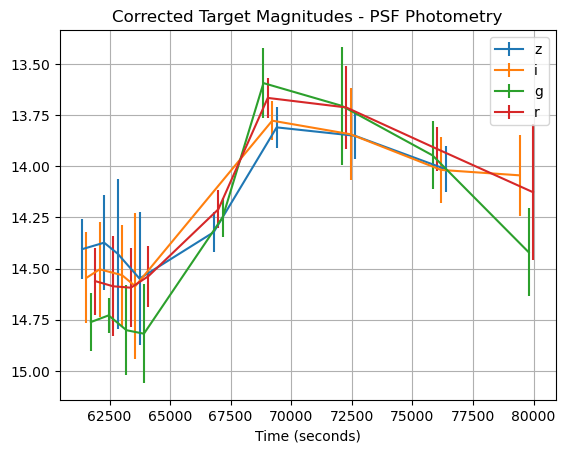

In [31]:
plt.gca().invert_yaxis()
for x in time_series.keys():
    plt.errorbar(time_series_psf[x], target_magnitudes_psf[x],label=x, yerr = tar_mag_errs_psf[x])
plt.legend()
plt.title("Corrected Target Magnitudes - PSF Photometry")
plt.savefig("Corrected Target Magnitudes - PSF Photometry")
plt.xlabel("Target Magnitude")
plt.xlabel("Time (seconds)")
plt.grid(True)